### **test**

In [99]:
import numpy as np
import pandas as pd
import gzip
import json
from collections import defaultdict
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
import multiprocessing

# def filter_2017_data(file_path):
#     data_2017 = []
#     with gzip.open(file_path, 'r') as f:
#         for line in f:
#             entry = json.loads(line)
#             review_date = entry.get('review_date')
#             if review_date:
#                 try:
#                     date = datetime.strptime(review_date, "%B %d, %Y")
#                     if date.year == 2017 & date.year == 2016:
#                         data_2017.append(entry)
#                 except ValueError:
#                     continue
#     return data_2017

def load_data(file_path):
    dataset = []
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        for line in f:
            dataset.append(json.loads(line))
    return dataset


## computing tfidf

In [100]:
def train_word2vec(data):
    sentences = [entry["review_text"].split() for entry in data if "review_text" in entry]
    model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=multiprocessing.cpu_count())
    
    # 计算每个 item 的 Word2Vec 向量（取均值）
    item_word2vec = {}
    for entry in data:
        item_id = entry["item_id"]
        words = entry.get("review_text", "").split()
        vectors = [model.wv[word] for word in words if word in model.wv]
        item_word2vec[item_id] = np.mean(vectors, axis=0) if vectors else np.zeros(100)
    
    return model, item_word2vec

# 🔥 3️⃣ 计算 TF-IDF
def compute_tfidf_features(data):
    vectorizer = TfidfVectorizer(max_features=500)
    review_texts = [entry.get('review_text', '') for entry in data]
    tfidf_matrix = vectorizer.fit_transform(review_texts)

    item_tfidf = {
        entry['item_id']: tfidf_matrix[i].toarray().flatten()
        for i, entry in enumerate(data)
    }
    return vectorizer, item_tfidf

In [101]:
def classify_rating(rating):
    if rating is None:  # 处理 None 值
        return 'medium'  # 设置默认分类

    rating = int(rating)  # 确保转换不会出错
    if rating >= 8:
        return 'high'
    elif 6 <= rating <= 7:
        return 'medium'
    else:
        return 'low'

# 在 `prepare_data_fast()` 里填充默认值
df["rating"] = df["rating"].fillna(6)  # 先填充 NaN
df["label"] = df["rating"].apply(classify_rating)

/var/folders/31/d8_mdwcs6k53znfr05m5f2mw0000gn/T/ipykernel_63940/2184874312.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rating"] = df["rating"].fillna(6)  # 先填充 NaN
/var/folders/31/d8_mdwcs6k53znfr05m5f2mw0000gn/T/ipykernel_63940/2184874312.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label"] = df["rating"].apply(classify_rating)


In [102]:
def prepare_data_fast(data, item_tfidf, item_word2vec):
    sia = SentimentIntensityAnalyzer()
    df = pd.DataFrame(data)

    # 1️⃣ 计算情感分数
    df["sentiment_score"] = df["review_text"].fillna("").apply(lambda text: sia.polarity_scores(text)["compound"])

    # 2️⃣ 获取 TF-IDF & Word2Vec 向量
    df["tfidf_vector"] = df["item_id"].apply(lambda item_id: item_tfidf.get(item_id, np.zeros(500)))
    df["word2vec_vector"] = df["item_id"].apply(lambda item_id: item_word2vec.get(item_id, np.zeros(100)))

    # 3️⃣ 预计算用户历史
    user_history = defaultdict(list)
    df["user_history"] = df["user_id"].apply(lambda user_id: user_history[user_id][:])

    # 4️⃣ 更新历史记录
    for _, row in df.iterrows():
        user_history[row["user_id"]].append(row["item_id"])

    # 5️⃣ 转换 `rating` 为分类标签
    df["label"] = df["rating"].apply(classify_rating)

    # 6️⃣ 转换为列表
    features = df[["user_id", "item_id", "sentiment_score", "tfidf_vector", "word2vec_vector", "user_history"]].to_dict("records")
    labels = df["label"].tolist()

    return features, labels

In [103]:
def calculate_similarity(item_id, user_history, item_tfidf, item_word2vec, w_tfidf=0.5, w_word2vec=0.5):
    if not user_history or item_id not in item_tfidf or item_id not in item_word2vec:
        return 0

    tfidf_vectors = [item_tfidf[item] for item in user_history if item in item_tfidf]
    tfidf_similarity = np.mean(cosine_similarity([item_tfidf[item_id]], tfidf_vectors)) if tfidf_vectors else 0

    word2vec_vectors = [item_word2vec[item] for item in user_history if item in item_word2vec]
    word2vec_similarity = np.mean(cosine_similarity([item_word2vec[item_id]], word2vec_vectors)) if word2vec_vectors else 0

    return w_tfidf * tfidf_similarity + w_word2vec * word2vec_similarity

In [104]:
# 数据划分
def split_data(features, labels, test_size=0.2):
    data = list(zip(features, labels))
    np.random.shuffle(data)
    split_index = int(len(data) * (1 - test_size))
    return data[:split_index], data[split_index:]

In [105]:
# 推荐分数计算
def calculate_recommend_score(sentiment_score, similarity_score, w1, w2):
    return w1 * sentiment_score + w2 * similarity_score

In [106]:
def evaluate_weights(data, w1, w2, item_tfidf, item_word2vec):
    y_true = []
    y_pred = []
    for feature, label in data:
        sentiment_score = feature['sentiment_score']
        similarity_score = calculate_similarity(feature['item_id'], feature['user_history'], item_tfidf, item_word2vec)
        score = w1 * sentiment_score + w2 * similarity_score
        predicted_label = 'high' if score >= 0.5 else 'medium' if 0.5 > score >= 0.2 else 'low'
        y_true.append(label)
        y_pred.append(predicted_label)
    return np.mean(np.array(y_true) == np.array(y_pred))

In [107]:
# 网格搜索优化权重
def optimize_weights(train_data, item_tfidf, item_word2vec):
    best_w1, best_w2, best_accuracy = 0, 0, 0
    for w1 in np.linspace(0.1, 0.9, 11):
        w2 = 1 - w1
        accuracy = evaluate_weights(train_data, w1, w2, item_tfidf, item_word2vec)
        if accuracy > best_accuracy:
            best_w1, best_w2, best_accuracy = w1, w2, accuracy
    return best_w1, best_w2, best_accuracy

In [108]:
# 最终推荐系统
def final_recommendation(features, w1, w2, item_tfidf):
    recommendations = defaultdict(list)
    for feature in features:
        user_id = feature['user_id']
        item_id = feature['item_id']
        sentiment_score = feature['sentiment_score']
        similarity_score = calculate_similarity(item_id, feature['user_history'], item_tfidf)
        
        score = calculate_recommend_score(sentiment_score, similarity_score, w1, w2)
        recommendations[user_id].append((item_id, score))
    
    # 按分数排序
    for user_id in recommendations:
        recommendations[user_id] = sorted(recommendations[user_id], key=lambda x: x[1], reverse=True)
    
    return recommendations

In [109]:
if __name__ == "__main__":
    print("🚀 加载数据...")
    data = load_data("renttherunway_final_data.json.gz")

    print("📊 计算 TF-IDF 和 Word2Vec...")
    vectorizer, item_tfidf = compute_tfidf_features(data)
    word2vec_model, item_word2vec = train_word2vec(data)

    print("⚡ 处理数据...")
    features, labels = prepare_data_fast(data, item_tfidf, item_word2vec)

    print("🔀 数据划分...")
    train_data, val_data = split_data(features, labels)

    print("🎯 优化权重...")
    best_w1, best_w2, best_accuracy = optimize_weights(train_data, item_tfidf, item_word2vec)
    print(f"最佳权重: w1={best_w1}, w2={best_w2}, 准确率={best_accuracy}")

    print("✅ 代码运行完成！")

🚀 加载数据...
📊 计算 TF-IDF 和 Word2Vec...
⚡ 处理数据...
🔀 数据划分...
🎯 优化权重...
最佳权重: w1=0.9, w2=0.09999999999999998, 准确率=0.831304573635862
✅ 代码运行完成！


## --------------分割线----------------

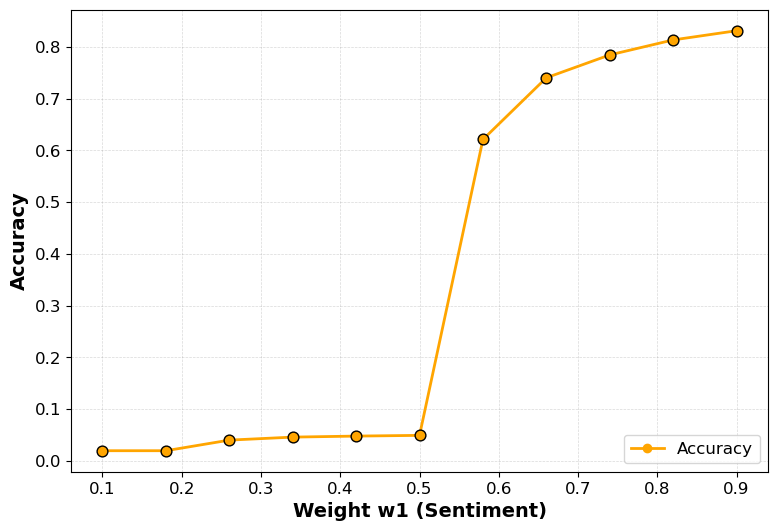

In [121]:
def evaluate_weights(data, w1, w2, item_tfidf, item_word2vec, w_tfidf=0.5, w_word2vec=0.5):
    y_true = []
    y_pred = []
    
    for feature, label in data:
        sentiment_score = feature['sentiment_score']
        similarity_score = calculate_similarity(
            feature['item_id'], feature['user_history'], 
            item_tfidf, item_word2vec, 
            w_tfidf, w_word2vec  # 传入 TF-IDF 和 Word2Vec 权重
        )
        
        score = w1 * sentiment_score + w2 * similarity_score
        predicted_label = 'high' if score >= 0.5 else 'medium' if 0.5 > score >= 0.2 else 'low'
        
        y_true.append(label)
        y_pred.append(predicted_label)
    
    return np.mean(np.array(y_true) == np.array(y_pred))  # 计算准确率

import matplotlib.pyplot as plt
import numpy as np

accuracies = []
weights = np.linspace(0.1, 0.9, 11)

for w1 in weights:
    w2 = 1 - w1  # 保证 w1 + w2 = 1
    accuracy = evaluate_weights(
        train_data, w1, w2, 
        item_tfidf=item_tfidf, 
        item_word2vec=item_word2vec, 
        w_tfidf=0.5,  
        w_word2vec=0.5
    )
    accuracies.append(accuracy)

# 🎨 绘制美观优化后的曲线
plt.figure(figsize=(9, 6), facecolor="white")  # 增加图表大小 & 白色背景
plt.plot(weights, accuracies, marker='o', linestyle='-', color="orange", linewidth=2, label="Accuracy")  # 线条颜色：深靛蓝
plt.scatter(weights, accuracies, color="orange", edgecolors='black', s=60, zorder=3)  # 点颜色：橙红，带黑色边框

# 🌈 美化细节
plt.xlabel("Weight w1 (Sentiment)", fontsize=14, fontweight="bold")
plt.ylabel("Accuracy", fontsize=14, fontweight="bold")
# 🌟 增强视觉效果
plt.legend(fontsize=12, loc="lower right")
plt.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.3)  # 半透明网格
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [50]:
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import string
from nltk.corpus import stopwords
from nltk.util import ngrams
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import re as re
from wordcloud import WordCloud
from collections import Counter
import numpy as np
stop_words=set(stopwords.words("english"))

In [51]:
# functions for cleaning
def search_words(text):
    result = re.findall(r'\b[^\d\W]+\b', text)
    return " ".join(result)

def process_raw_text(text):    
    # Tokenize words
    tokeniser = RegexpTokenizer(r'[A-Za-z]{2,}')
    tokens = tokeniser.tokenize(text)
    
    # Lowercase, lemmatize and remove stopwords
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token.lower(), pos='v') for token in tokens]
    lemmas = [token.lower() for token in lemmas]    
    
    clean = [lemma for lemma in lemmas if lemma not in stop_words]
    return clean

def frequent_ngram(corpus, ngram, n=30):    
    # Preprocess each document
    documents = [process_raw_text(document) for document in corpus]
    
    # Find ngrams per document and put into one long list
    n_grams = [list(ngrams(document, ngram)) for document in documents]
    n_grams_flat = [item for sublist in n_grams for item in sublist]
    
    # get frequencies of ngrams
    freq_dist = FreqDist(n_grams_flat)
    top_freq = freq_dist.most_common(n)
    theDF = pd.DataFrame(top_freq, columns=["ngram", "count"])     

    tmp = theDF
    tmp['ngram'] = tmp['ngram'].astype('string')
    tmp['ngram']=tmp['ngram'].apply(lambda x : search_words(x))

    return tmp

In [52]:
data = load_data("renttherunway_final_data.json.gz")
df = pd.DataFrame(data)
df

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192539,fit,66386,34dd,2252812,140lbs,10,work,Fit like a glove!,hourglass,LOVE IT!!! First Item Im thinking of buying!,jumpsuit,"5' 9""",8,42,"May 18, 2016"
192540,fit,118398,32c,682043,100lbs,10,work,The pattern contrast on this dress is really s...,petite,LOVE it!,dress,"5' 1""",4,29,"September 30, 2016"
192541,fit,47002,36a,683251,135lbs,6,everyday,"Like the other DVF wraps, the fit on this is f...",straight & narrow,"Loud patterning, flattering fit",dress,"5' 8""",8,31,"March 4, 2016"
192542,fit,961120,36c,126335,165lbs,10,wedding,This dress was PERFECTION. it looked incredib...,pear,loved this dress it was comfortable and photog...,dress,"5' 6""",16,31,"November 25, 2015"


In [53]:
df_unigrams = frequent_ngram(df['review_text'],2,20)
word_freq = dict(zip(df_unigrams['ngram'], df_unigrams['count']))

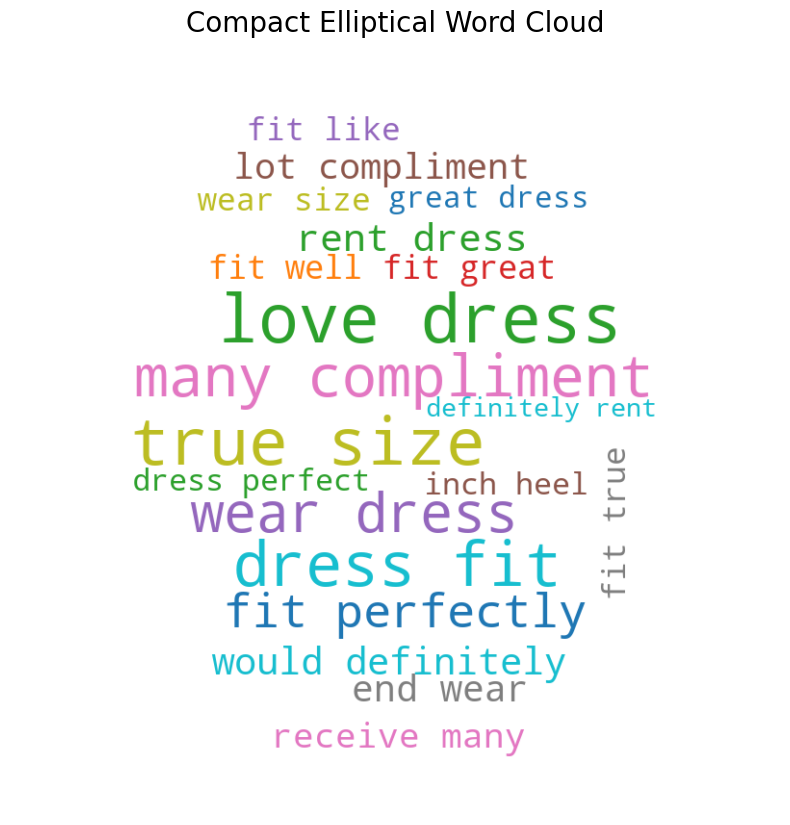

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 创建 800x800 的椭圆形掩码
x, y = np.ogrid[:800, :800]
center_x, center_y = 400, 400
radius_x, radius_y = 390, 280  # 适当减小半径，使椭圆更紧凑
mask = ((x - center_x) / radius_x) ** 2 + ((y - center_y) / radius_y) ** 2 > 1
mask = mask.astype(np.uint8) * 255  # 需要转换为 uint8 类型（0-255）


# 创建紧凑的椭圆形词云
wordcloud = WordCloud(
    width=800,
    height=800,
    background_color="white",
    mask=mask,  # 确保正确使用掩码
    colormap="tab10",
    prefer_horizontal=0.85,  # 让更多单词横向排列，减少空白
    relative_scaling=0.8,  # 让低频单词更紧凑
    max_words=200,  # 显示更多单词
    max_font_size=70,  # 限制最大字体，防止形状变形
    min_font_size=10,
    collocations=False,
    margin=0  # 取消单词间距，使其更紧凑
).generate_from_frequencies(word_freq)

# 显示词云
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # 去掉坐标轴
plt.title("Compact Elliptical Word Cloud", fontsize=20, pad=10)
plt.show()

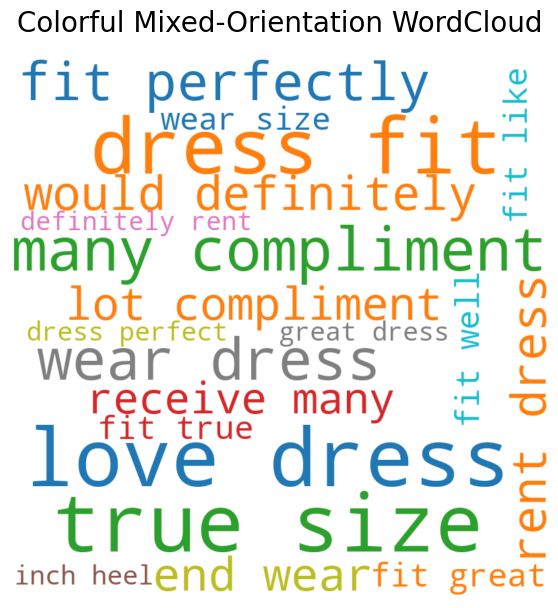

In [55]:
wordcloud = WordCloud(
    width=800,
    height=800,
    background_color="white",  # 背景颜色为白色
    colormap="tab10",  # 丰富的颜色方案
    prefer_horizontal=0.5,  # 横竖混合，50% 水平
    relative_scaling=0.4,  # 缩放平衡，增加小频率单词的可见性
    max_font_size=120,  # 最大字体大小
    min_font_size=10,  # 最小字体大小
    collocations=False,  # 禁用双词短语
    margin=2  # 减少单词之间的间距
).generate_from_frequencies(word_freq)

# 显示词云
plt.figure(figsize=(7, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # 去掉边框和坐标轴
plt.title("Colorful Mixed-Orientation WordCloud", fontsize=20, pad=20)
plt.show()

/var/folders/31/d8_mdwcs6k53znfr05m5f2mw0000gn/T/ipykernel_63940/1689342913.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20c', len(df_unigrams))  # 使用 'tab20c' 调色板，适合较多类别
/var/folders/31/d8_mdwcs6k53znfr05m5f2mw0000gn/T/ipykernel_63940/1689342913.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/31/d8_mdwcs6k53znfr05m5f2mw0000gn/T/ipykernel_63940/1689342913.py:8: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


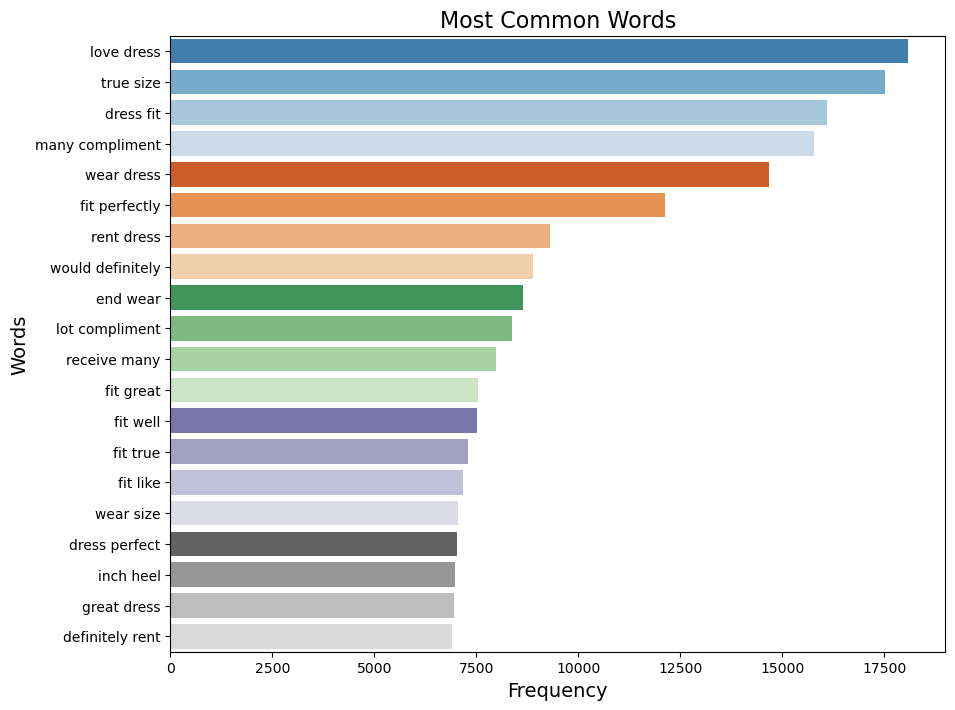

In [56]:
import matplotlib.cm as cm
import numpy as np

# 动态生成颜色
colors = cm.get_cmap('tab20c', len(df_unigrams))  # 使用 'tab20c' 调色板，适合较多类别

plt.figure(figsize=(10, 8))
sns.barplot(
    x="count", 
    y="ngram", 
    data=df_unigrams, 
    palette=colors(np.linspace(0, 1, len(df_unigrams)))  # 为每个条形指定颜色
)
plt.title("Most Common Words", fontsize=16)
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Words", fontsize=14)
plt.show()

In [57]:
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')  # 非数字转为 NaN
df = df.dropna(subset=['rating'])  # 删除缺失值
df['rating'] = df['rating'].astype(int)

df_low = df[df['rating'] < 6]

df_low

/var/folders/31/d8_mdwcs6k53znfr05m5f2mw0000gn/T/ipykernel_63940/2757461454.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rating'] = df['rating'].astype(int)


,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
42,small,126879,36c,1406963,155lbs,4,wedding,Huge on top and super tight in the waist,pear,strange fit,dress,"5' 4""",28,38,"June 20, 2017"
131,fit,832715,36d,1871026,175lbs,4,work,"Loved the look of this dress on the hanger, bu...",hourglass,"Nice, but not for curves",dress,"5' 7""",24,32,"April 12, 2016"
152,small,898006,38d,135750,NaN,2,wedding,"The dress was much shorter than it appeared, t...",hourglass,Wasn't able to wear,shift,"5' 6""",24,32,"August 19, 2013"
179,fit,483798,36d,1526552,178lbs,4,work,this was not flattering on my curves. Didn't ...,pear,Not cute on an hourglass shape,dress,"5' 7""",24,41,"October 2, 2017"
181,small,979081,32d,1689615,130lbs,2,vacation,So I didn't get a backup of this dress because...,hourglass,Too small-couldn't zip up.,gown,"5' 3""",4,28,"April 22, 2017"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192166,fit,733501,36d,782079,NaN,4,formal affair,I rented this dress for a gala and it was noth...,hourglass,"Frumpy, Frumpy, Frumpy",gown,"5' 6""",21,26,"April 3, 2016"
192246,fit,691468,34c,649983,125lbs,4,everyday,"while very soft with a nice casual pattern, th...",full bust,not for my body type,dress,"5' 3""",8,31,"August 21, 2015"
192290,fit,240021,32d,265806,NaN,2,other,Beware if you are bustier. This is not friendl...,athletic,Not friendly to busty women,maxi,"5' 6""",12,30,"July 12, 2017"
192507,fit,813530,34a,1178721,120lbs,4,party,This dress was sent to me when the backup size...,petite,"Fun Dress, But Needs a Certain Body Type",dress,"5' 1""",8,27,"June 22, 2015"


In [58]:
df_low_unigrams = frequent_ngram(df_low['review_text'],2,100)
word_freq_low = dict(zip(df_low_unigrams['ngram'], df_low_unigrams['count']))
df_low_unigrams

,ngram,count
0,end wear,364
1,wear dress,333
2,look like,268
3,make look,225
4,dress fit,221
...,...,...
95,return without,38
96,receive dress,37
97,fit better,37
98,beautiful color,37


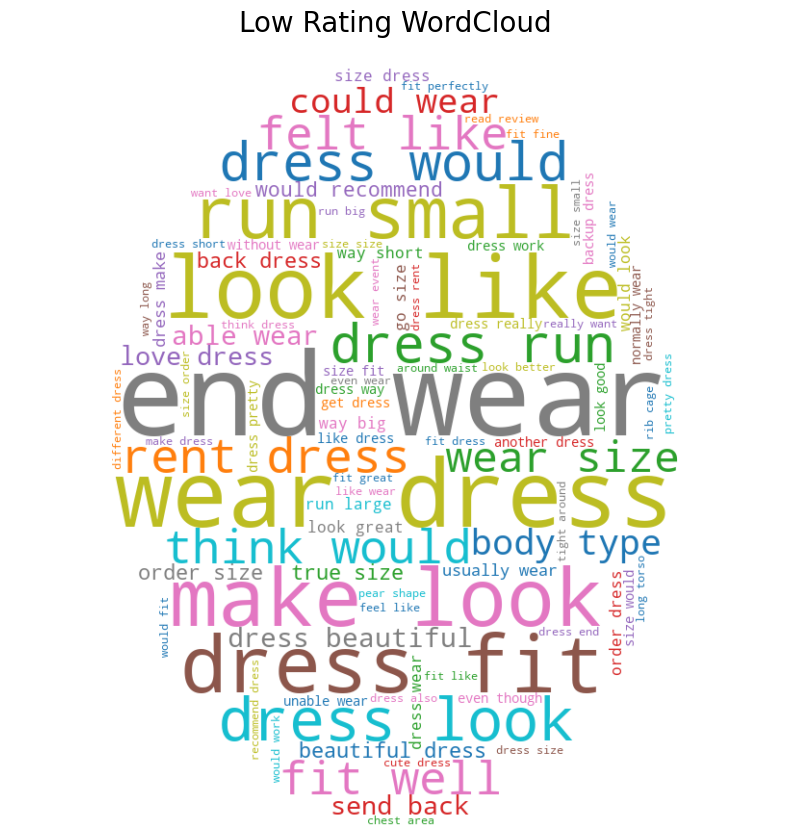

In [59]:
x, y = np.ogrid[:800, :800]  # 创建 800x800 网格
center_x, center_y = 400, 400  # 椭圆中心
radius_x, radius_y = 400, 300  # 椭圆横向和纵向半径
mask = ((x - center_x) / radius_x) ** 2 + ((y - center_y) / radius_y) ** 2 > 1
mask = 255 * mask.astype(int)  # 转换为词云可用的格式
# 创建词云
wordcloud = WordCloud(
    width=800,
    height=800,
    background_color="white",
    mask=mask,  # 使用椭圆掩码
    colormap="tab10",  # 丰富的颜色风格
    prefer_horizontal=0.7,  # 横竖文字比例平衡
    relative_scaling=0.4,  # 让低频单词也可见
    max_font_size=120,
    min_font_size=10,
    collocations=False,
    margin=2  # 减少单词间的间距
).generate_from_frequencies(word_freq_low)

# 显示词云
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # 去掉坐标轴
plt.title("Low Rating WordCloud", fontsize=20, pad=20)
plt.show()

In [60]:
df_high = df[df['rating'] >= 6]
df_high_unigrams = frequent_ngram(df_high['review_text'],2,100)
word_freq_high = dict(zip(df_high_unigrams['ngram'], df_high_unigrams['count']))
df_high_unigrams

,ngram,count
0,love dress,17979
1,true size,17435
2,dress fit,15866
3,many compliment,15757
4,wear dress,14322
...,...,...
95,like dress,2627
96,make sure,2617
97,dress definitely,2604
98,fit dress,2589


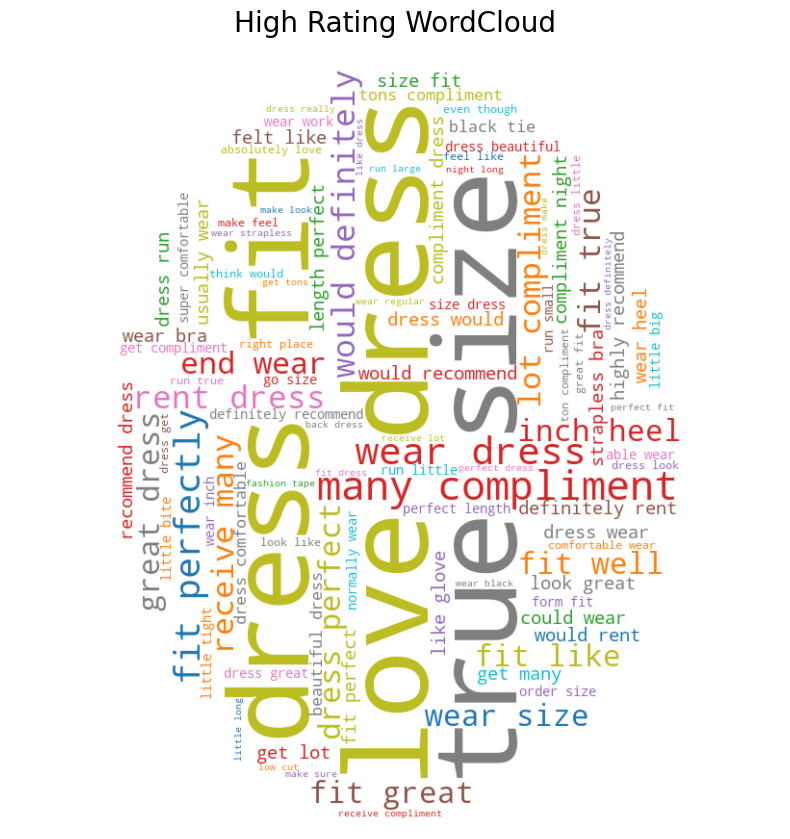

In [61]:
x, y = np.ogrid[:800, :800]  # 创建 800x800 网格
center_x, center_y = 400, 400  # 椭圆中心
radius_x, radius_y = 400, 300  # 椭圆横向和纵向半径
mask = ((x - center_x) / radius_x) ** 2 + ((y - center_y) / radius_y) ** 2 > 1
mask = 255 * mask.astype(int)  # 转换为词云可用的格式
# 创建词云
wordcloud = WordCloud(
    width=800,
    height=800,
    background_color="white",
    mask=mask,  # 使用椭圆掩码
    colormap="tab10",  # 丰富的颜色风格
    prefer_horizontal=0.7,  # 横竖文字比例平衡
    relative_scaling=0.4,  # 让低频单词也可见
    max_font_size=120,
    min_font_size=10,
    collocations=False,
    margin=2  # 减少单词间的间距
).generate_from_frequencies(word_freq_high)

# 显示词云
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # 去掉坐标轴
plt.title("High Rating WordCloud", fontsize=20, pad=20)
plt.show()

In [62]:
import nltk
#nltk.download("vader_lexicon") # only need to run this once
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()
import pandas as pd

In [63]:
df["score"] = df["review_text"].apply(lambda text: vader.polarity_scores(text))
df["compound"] = df["score"].apply(lambda score_dict: score_dict["compound"])
df

/var/folders/31/d8_mdwcs6k53znfr05m5f2mw0000gn/T/ipykernel_63940/3839702256.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["score"] = df["review_text"].apply(lambda text: vader.polarity_scores(text))
/var/folders/31/d8_mdwcs6k53znfr05m5f2mw0000gn/T/ipykernel_63940/3839702256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["compound"] = df["score"].apply(lambda score_dict: score_dict["compound"])


,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,score,compound
0,fit,420272,34d,2260466,137lbs,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016","{'neg': 0.023, 'neu': 0.648, 'pos': 0.33, 'com...",0.9453
1,fit,273551,34b,153475,132lbs,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013","{'neg': 0.048, 'neu': 0.683, 'pos': 0.268, 'co...",0.8991
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015","{'neg': 0.0, 'neu': 0.701, 'pos': 0.299, 'comp...",0.9333
3,fit,909926,34c,126335,135lbs,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014","{'neg': 0.037, 'neu': 0.727, 'pos': 0.236, 'co...",0.9559
4,fit,151944,34b,616682,145lbs,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016","{'neg': 0.0, 'neu': 0.945, 'pos': 0.055, 'comp...",0.6948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192539,fit,66386,34dd,2252812,140lbs,10,work,Fit like a glove!,hourglass,LOVE IT!!! First Item Im thinking of buying!,jumpsuit,"5' 9""",8,42,"May 18, 2016","{'neg': 0.0, 'neu': 0.159, 'pos': 0.841, 'comp...",0.6476
192540,fit,118398,32c,682043,100lbs,10,work,The pattern contrast on this dress is really s...,petite,LOVE it!,dress,"5' 1""",4,29,"September 30, 2016","{'neg': 0.052, 'neu': 0.74, 'pos': 0.208, 'com...",0.8951
192541,fit,47002,36a,683251,135lbs,6,everyday,"Like the other DVF wraps, the fit on this is f...",straight & narrow,"Loud patterning, flattering fit",dress,"5' 8""",8,31,"March 4, 2016","{'neg': 0.08, 'neu': 0.776, 'pos': 0.144, 'com...",0.4072
192542,fit,961120,36c,126335,165lbs,10,wedding,This dress was PERFECTION. it looked incredib...,pear,loved this dress it was comfortable and photog...,dress,"5' 6""",16,31,"November 25, 2015","{'neg': 0.082, 'neu': 0.663, 'pos': 0.255, 'co...",0.9623


/var/folders/31/d8_mdwcs6k53znfr05m5f2mw0000gn/T/ipykernel_63940/2666831390.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["review_date"] = pd.to_datetime(df["review_date"])
/var/folders/31/d8_mdwcs6k53znfr05m5f2mw0000gn/T/ipykernel_63940/2666831390.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["year"] = df["review_date"].dt.year
/var/folders/31/d8_mdwcs6k53znfr05m5f2mw0000gn/T/ipykernel_63940/2666831390.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singu

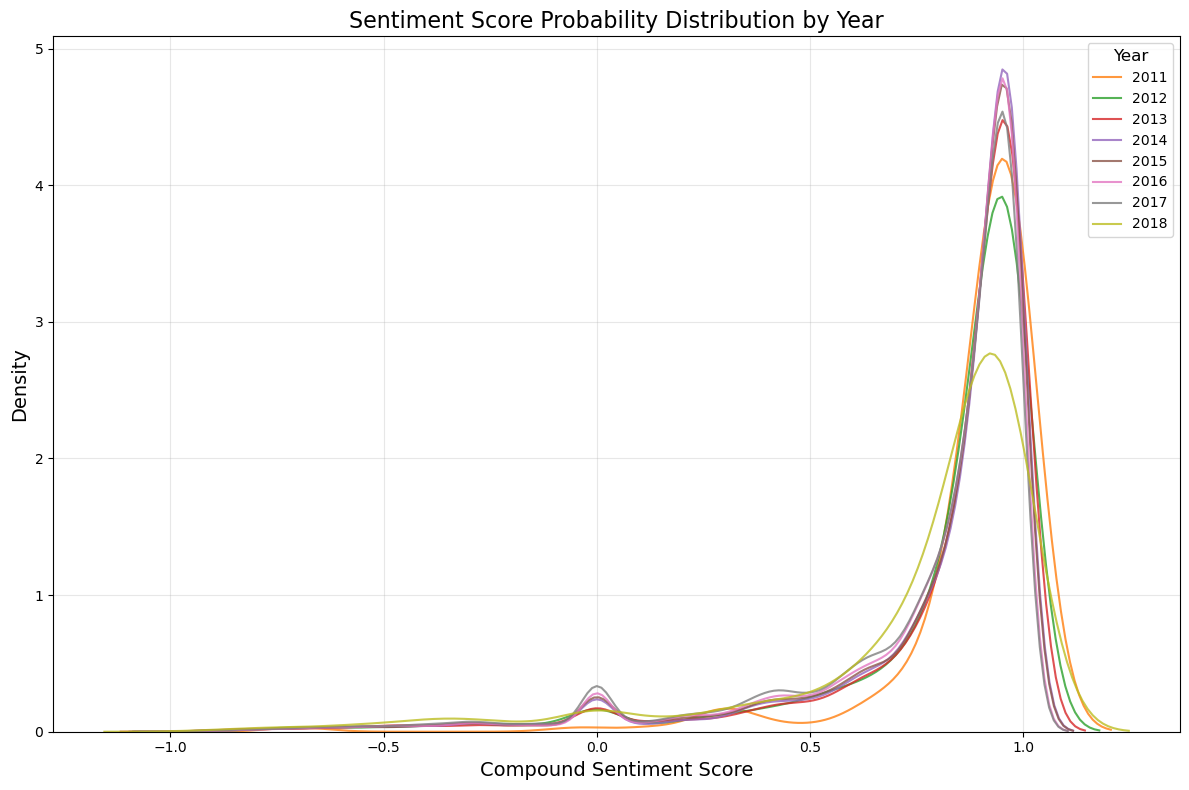

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df["review_date"] = pd.to_datetime(df["review_date"])
df["year"] = df["review_date"].dt.year

plt.figure(figsize=(12, 8))

# 按年份绘制 compound 得分的概率分布
for year, group in df.groupby("year"):
    sns.kdeplot(
        group["compound"],  # compound 分数
        label=str(year),  # 图例显示年份
        fill=False,  # 填充区域
        alpha=0.8  # 填充透明度
    )

# 添加标题和标签
plt.title("Sentiment Score Probability Distribution by Year", fontsize=16)
plt.xlabel("Compound Sentiment Score", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(title="Year", fontsize=10, title_fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# 显示图表
plt.show()

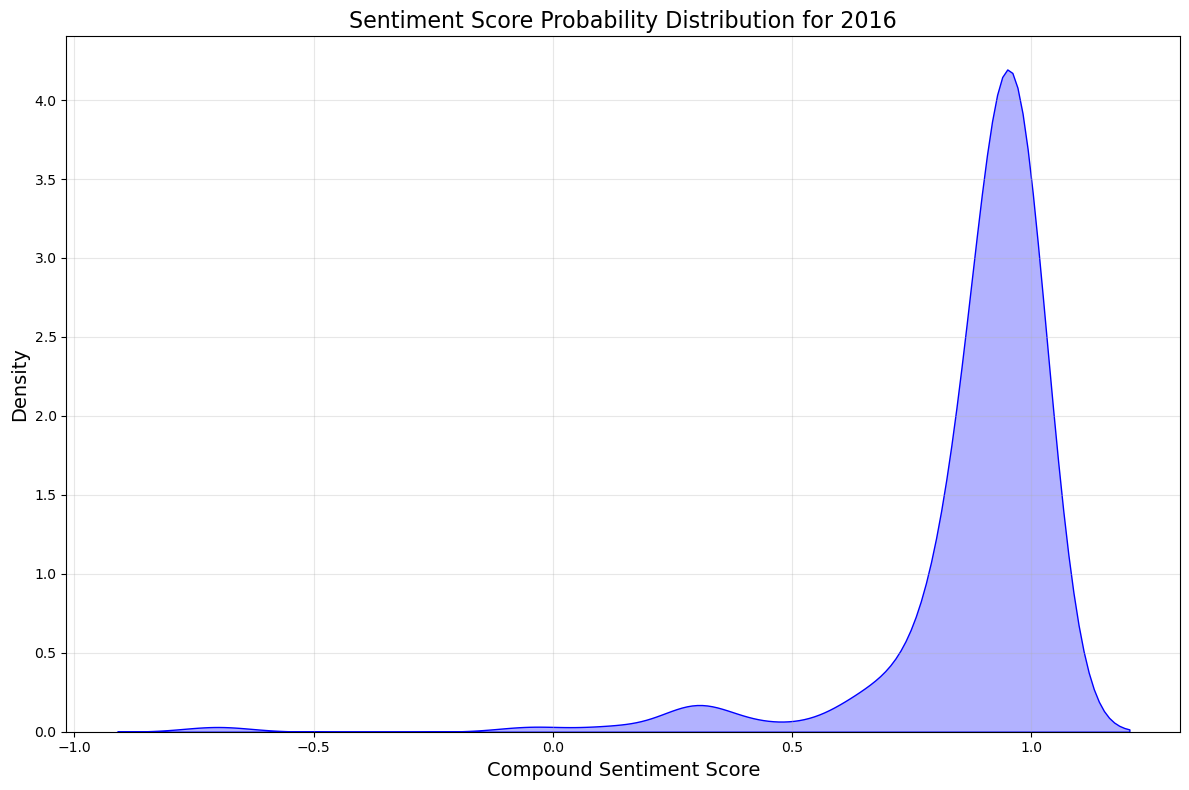

In [65]:
df_2016 = df[df["year"] == 2011]

# 创建画布
plt.figure(figsize=(12, 8))

# 绘制 2016 年情感得分的概率分布
sns.kdeplot(
    df_2016["compound"],  # compound 列
    fill=True,            # 填充曲线下方
    color="blue",         # 曲线颜色
    alpha=0.3             # 填充透明度
)

# 添加标题和标签
plt.title("Sentiment Score Probability Distribution for 2016", fontsize=16)
plt.xlabel("Compound Sentiment Score", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.grid(alpha=0.3)

# 显示图表
plt.tight_layout()
plt.show()